#### Import libraries

In [224]:
import river
from river import datasets
from river import linear_model, tree
from river import drift, metrics
from river.datasets import synth
import numpy as np
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from frouros.metrics import PrequentialError
from sklearn.pipeline import Pipeline
from frouros.detectors.concept_drift.streaming.window_based.adwin import ADWIN
from frouros.detectors.concept_drift import DDM, DDMConfig
from frouros.detectors.concept_drift.streaming.statistical_process_control.ddm import DDM
from frouros.detectors.concept_drift.streaming.statistical_process_control.eddm import EDDM,EDDMConfig
from frouros.detectors.concept_drift.streaming.change_detection.page_hinkley import PageHinkley


#### Returns the DataFrame containing the generated data

In [59]:
def initialize_data(dp1, dp2, seed=42):
    """
    Initialize the dataset with specified drift position and seed.
    
    Parameters:
    - a (int): The start position where the drift occurs.
    - b (int): The end position where the drift occurs and also used as the limit.
    - seed (int): Random seed for reproducibility.
    
    Returns:
    - pd.DataFrame: DataFrame containing the generated data.
    """
    dataset = synth.FriedmanDrift(
        drift_type='gra',
        position=(dp1, dp2),
        seed=seed
    )
    data = []
    for i, (x, y) in enumerate(dataset):
        x_values = list(x.values())
        data.append(x_values + [y])
        if i >= dp2:  # Limiting to 'b' samples for simplicity
            break
    column_names = [f'x{i}' for i in range(1, len(x_values) + 1)] + ['y']
    df = pd.DataFrame(data, columns=column_names)
    return df

#### Split the Data into Training and Streaming Sets

In [8]:
def split_data(df, split):
    """
    Split the dataset into training, validation, and streaming sets.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the dataset.
    - split (int): Index in which we split the data in to train and tream.
    
    
    Returns:
    - train (pd.DataFrame): Training set.
    - val (pd.DataFrame): Validation set.
    - stream (pd.DataFrame): Streaming set.
    """
    # Split the DataFrame into train and remaining data
    train = df.iloc[:split]
    stream = df.iloc[split:]
    
    # Split the train data into training and validation sets
    train, val = train_test_split(train, test_size=0.2, random_state=42)
    
    return train, val, stream


#### Set Up the Pipeline and Train the Model

In [46]:
def train_model(train,model):
    X_train = train.drop(columns='y').values
    y_train = train['y'].values
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model)])
    pipeline.fit(X_train, y_train)
    return pipeline

#### Quantile-Based Thresholding

In [297]:
def calculate_threshold(pipeline, val, quantile_threshold):
    """
    Calculate the quantile-based threshold for error values.
    
    Parameters:
    - pipeline: The trained pipeline used for predictions.
    - val (pd.DataFrame): Validation set containing features and target variable.
    - quantile_threshold (float): The quantile threshold to determine the error threshold.
    
    Returns:
    - threshold (float): The calculated quantile-based threshold.
    """
    # Extract features and target variable from the validation set
    X_val = val.drop(columns='y').values
    y_val = val['y'].values
    
    # Make predictions using the pipeline
    y_pred = pipeline.predict(X_val)
    
    # Calculate the squared errors
    errors_val = (y_val - y_pred) ** 2
    
    # Calculate the quantile-based threshold
    threshold = np.quantile(errors_val, quantile_threshold)
    print(f"Calculated threshold at {quantile_threshold * 100}% quantile: {threshold}")
    
    return threshold


#### Initialize and Update the Drift Detector

### DDM

In [18]:
def setup_ddm(warning_level=2.0, drift_level=3.0, min_num_instances=1000):
    """
    Set up the DDM detector with specified configuration parameters.
    
    Parameters:
    - warning_level (float): The warning level for drift detection.
    - drift_level (float): The drift level for drift detection.
    - min_num_instances (int): Minimum number of instances before checking for concept drift.
    
    Returns:
    - detector: An instance of the DDM drift detector.
    """
    config = DDMConfig(
        warning_level=warning_level,
        drift_level=drift_level,
        min_num_instances=min_num_instances
    )
    detector = DDM(config=config)
    return detector

### EDDM

In [20]:
def setup_eddm(alpha=0.95, beta=0.9, level=2.0, min_num_misclassified_instances=30):
    """
    Set up the EDDM (Early Drift Detection Method) detector with specified configuration parameters.
    
    Parameters:
    - alpha (float): Warning zone value.
    - beta (float): Change zone value.
    - level (float): Level factor for drift detection.
    - min_num_misclassified_instances (int): Minimum number of misclassified instances to start detecting drift.
    
    Returns:
    - detector: An instance of the EDDM drift detector.
    """
    config = EDDMConfig(
        alpha=alpha,
        beta=beta,
        level=level,
        min_num_misclassified_instances=min_num_misclassified_instances
    )
    detector = EDDM(config=config)
    return detector

#### Process the Streaming Data

In [295]:
def process_stream(X, y, pipeline, detector, threshold, odp):
    detected_drifts = []
    false_alarms = 0
    detection_delays = []
    y_preds = []
    errors = []
    
   

    for i in range(len(X)):
        X_i = X[i].reshape(1, -1)
        y_i = y[i].reshape(1, -1)
        y_pred = pipeline.predict(X_i)
        y_preds.append(y_pred[0])
        error = mean_squared_error(y_i, y_pred)
        errors.append(error)
        binary_error = 1 if error > threshold else 0
       
        detector.update(value=binary_error)

        if detector.drift:
            detected_drifts.append(i + len(train)+len(val))
            if i + len(train)+len(val) < odp:
                false_alarms += 1
            else:
                detection_delays.append((i + len(train)+len(val)) - odp)

        

    false_alarm_rate = (false_alarms / (odp-len(train)-len(val)) )* 100 if detected_drifts else 0
    detection_delay = detection_delays[0] if detection_delays else None
    return false_alarm_rate, detection_delay, errors, detected_drifts


#### Plot Error distribution

In [32]:
def plot_errors(errors: List[float]) -> None:
    """
    Plot the Mean Squared Error (MSE) values over data points.

    Parameters:
    - errors (List[float]): List of MSE error values to plot.

    Returns:
    - None
    """
    plt.figure(figsize=(14, 7))
    plt.plot(range(len(errors)), errors, label="MSE Error", color='purple')
    plt.xlabel("Instance Index")
    plt.ylabel("Mean Squared Error")
    plt.title("Behavior of Mean Squared Error Over Data Points")
    plt.legend()
    plt.grid(True)
    plt.show()


#### Visualizing detected drifts against actual

In [37]:
def plot_drift_indicators(data_length: int, detected_drifts: List[int], odp: int):
    """
    Plot drift detection indicators and actual drift indicators.

    Parameters:
    - data_length (int): The length of the data array.
    - detected_drifts (List[int]): List of indices where drifts are detected.
    - odp (int): Index of the initial drift point.
    """
    # Create binary arrays for drift detection and odp
    drift_indicator = np.zeros(data_length)
    for drift_point in detected_drifts:
        if drift_point < data_length:
            drift_indicator[drift_point] = 1

    odp_indicator = np.zeros(data_length)
    for i in range(odp, data_length):
        odp_indicator[i] = 1

    # Plotting the drift indicator and odp indicator
    plt.figure(figsize=(12, 4))
    plt.plot(drift_indicator, label='Detected Drift Indicator', color='red', drawstyle='steps-post')
    plt.plot(odp_indicator, label='Actual Drift Indicator (ODP)', color='green', linestyle='-', drawstyle='steps-post')
    plt.xlabel('Index')
    plt.ylabel('Drift Detection (0 or 1)')
    plt.title('Drift Detection Indicator')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

#### Test Different Quantile Levels

In [300]:
def optimize_quantile(train, val, stream,detector,pipeline,start,end,step_size):
    best_quantile = None
    best_false_alarm_rate = float('inf')
    best_detection_delay = float('inf')
    best_detected_drifts = []  # Initialize to store the best detected drifts

    for quantile in np.arange(start, end, step_size):  # Test from 90th to 99th percentile
        
        threshold = calculate_threshold(pipeline, val, quantile)
        detector = detector  # Not necessary, but kept for clarity
        
        X_stream = stream.drop(columns='y').values
        y_stream = stream['y'].values
        false_alarm_rate, detection_delay, errors, detected_drifts = process_stream(X_stream, y_stream, pipeline, detector, threshold, odp=odp)

        print(f"Quantile: {quantile:.2f}")
        print(f"Threshold: {threshold:.2f}")
        print(f"False Alarm Rate: {false_alarm_rate:.2f}%")
        print(f"Detection Delay: {detection_delay}")
        #print(f"Detected Drifts: {detected_drifts}\n")

        if false_alarm_rate < best_false_alarm_rate or (false_alarm_rate == best_false_alarm_rate and (detection_delay is None or detection_delay < best_detection_delay)):
            best_quantile = quantile
            best_false_alarm_rate = false_alarm_rate
            best_detection_delay = detection_delay
            best_detected_drifts = detected_drifts  # Update the best detected drifts

    print(f"Best Quantile: {best_quantile}")
    print(f"Best False Alarm Rate: {best_false_alarm_rate}")
    print(f"Best Detection Delay: {best_detection_delay}")
    print(f"Best Detected Drifts: {best_detected_drifts}")
    
    return best_quantile, best_false_alarm_rate, best_detection_delay, best_detected_drifts

#### Test Different drift Levels - DDM

In [302]:
def optimize_drift_level(train, val, stream, pipeline, quantile_threshold,start,end,step_size):
    best_drift_level = None
    best_false_alarm_rate = float('inf')
    best_detection_delay = float('inf')
    best_detected_drifts = []

    # Fixed quantile threshold to calculate the threshold
    threshold = calculate_threshold(pipeline, val, quantile_threshold)
    
    # Test various drift levels
    for drift_level in np.arange(start,end,step_size):  # Adjust drift level range and step as needed
        detector = setup_ddm(drift_level-0.01,drift_level,30)
        
        X_stream = stream.drop(columns='y').values
        y_stream = stream['y'].values
        false_alarm_rate, detection_delay, errors, detected_drifts = process_stream(
            X_stream, y_stream, pipeline, detector, threshold, odp=odp)

        print(f"Drift Level: {drift_level:.2f}")
        print(f"Threshold: {threshold:.2f}")
        print(f"False Alarm Rate: {false_alarm_rate:.2f}%")
        print(f"Detection Delay: {detection_delay}")
        #print(f"Detected Drifts: {detected_drifts}\n")

        if false_alarm_rate < best_false_alarm_rate or (false_alarm_rate == best_false_alarm_rate and (detection_delay is None or detection_delay < best_detection_delay)):
            best_drift_level = drift_level
            best_false_alarm_rate = false_alarm_rate
            best_detection_delay = detection_delay
            best_detected_drifts = detected_drifts

    print(f"Best Drift Level: {best_drift_level}")
    print(f"Best False Alarm Rate: {best_false_alarm_rate}")
    print(f"Best Detection Delay: {best_detection_delay}")
    print(f"Best Detected Drifts: {best_detected_drifts}")
    
    return best_drift_level, best_false_alarm_rate, best_detection_delay, best_detected_drifts


#### Test Different parameters - EDDM

### alpha - drift level

In [238]:
def optimize_drift_level(train, val, stream, pipeline, quantile_threshold,start,end,step_size,level=0.2,mm=30):
    best_drift_level = None
    best_false_alarm_rate = float('inf')
    best_detection_delay = float('inf')
    best_detected_drifts = []

    # Fixed quantile threshold to calculate the threshold
    threshold = calculate_threshold(pipeline, val, quantile_threshold)
    
    # Test various drift levels
    for drift_level in np.arange(start,end,step_size):  # Adjust drift level range and step as needed
        detector = setup_eddm(drift_level,drift_level-0.01,level,mm)
        
        X_stream = stream.drop(columns='y').values
        y_stream = stream['y'].values
        false_alarm_rate, detection_delay, errors, detected_drifts = process_stream(
            X_stream, y_stream, pipeline, detector, threshold, odp=odp)

        print(f"Drift Level: {drift_level:.2f}")
        print(f"Threshold: {threshold:.2f}")
        print(f"False Alarm Rate: {false_alarm_rate:.2f}%")
        print(f"Detection Delay: {detection_delay}")
        #print(f"Detected Drifts: {detected_drifts}\n")

        if detection_delay is None or detection_delay < best_detection_delay or (detection_delay == best_detection_delay and false_alarm_rate < best_false_alarm_rate ):
            best_drift_level = drift_level
            best_false_alarm_rate = false_alarm_rate
            best_detection_delay = detection_delay
            best_detected_drifts = detected_drifts

    print(f"Best Drift Level: {best_drift_level}")
    print(f"Best False Alarm Rate: {best_false_alarm_rate}")
    print(f"Best Detection Delay: {best_detection_delay}")
    print(f"Best Detected Drifts: {best_detected_drifts}")
    
    return best_drift_level, best_false_alarm_rate, best_detection_delay, best_detected_drifts


### Level

In [240]:
def optimize_level(train, val, stream, pipeline, quantile_threshold,drift_level,start,end,step_size,mm=30):
    best_drift_level = None
    best_false_alarm_rate = float('inf')
    best_detection_delay = float('inf')
    best_detected_drifts = []

    # Fixed quantile threshold to calculate the threshold
    threshold = calculate_threshold(pipeline, val, quantile_threshold)
    
    # Test various drift levels
    for level in np.arange(start,end,step_size):  # Adjust drift level range and step as needed
        detector = setup_eddm(drift_level,drift_level-0.01,level,mm)
        
        X_stream = stream.drop(columns='y').values
        y_stream = stream['y'].values
        false_alarm_rate, detection_delay, errors, detected_drifts = process_stream(
            X_stream, y_stream, pipeline, detector, threshold, odp=odp)

        print(f"Drift Level: {drift_level:.2f}")
        print(f"Threshold: {threshold:.2f}")
        print(f"False Alarm Rate: {false_alarm_rate:.2f}%")
        print(f"Detection Delay: {detection_delay}")
        #print(f"Detected Drifts: {detected_drifts}\n")

        if detection_delay is None or detection_delay < best_detection_delay or (detection_delay == best_detection_delay and false_alarm_rate < best_false_alarm_rate ):
            best_drift_level = drift_level
            best_false_alarm_rate = false_alarm_rate
            best_detection_delay = detection_delay
            best_detected_drifts = detected_drifts

    print(f"Best Drift Level: {best_drift_level}")
    print(f"Best False Alarm Rate: {best_false_alarm_rate}")
    print(f"Best Detection Delay: {best_detection_delay}")
    print(f"Best Detected Drifts: {best_detected_drifts}")
    
    return best_drift_level, best_false_alarm_rate, best_detection_delay, best_detected_drifts


### Min Miss-classifications

In [247]:
def optimize_level(train, val, stream, pipeline, quantile_threshold,drift_level,start,end,step_size,level):
    best_drift_level = None
    best_false_alarm_rate = float('inf')
    best_detection_delay = float('inf')
    best_detected_drifts = []

    # Fixed quantile threshold to calculate the threshold
    threshold = calculate_threshold(pipeline, val, quantile_threshold)
    
    # Test various drift levels
    for mm in np.arange(start,end,step_size):  # Adjust drift level range and step as needed
        detector = setup_eddm(drift_level,drift_level-0.01,level,mm)
        
        X_stream = stream.drop(columns='y').values
        y_stream = stream['y'].values
        false_alarm_rate, detection_delay, errors, detected_drifts = process_stream(
            X_stream, y_stream, pipeline, detector, threshold, odp=odp)

        print(f"Drift Level: {drift_level:.2f}")
        print(f"Threshold: {threshold:.2f}")
        print(f"False Alarm Rate: {false_alarm_rate:.2f}%")
        print(f"Detection Delay: {detection_delay}")
        #print(f"Detected Drifts: {detected_drifts}\n")

        if detection_delay is None or detection_delay < best_detection_delay or (detection_delay == best_detection_delay and false_alarm_rate < best_false_alarm_rate ):
            best_drift_level = drift_level
            best_false_alarm_rate = false_alarm_rate
            best_detection_delay = detection_delay
            best_detected_drifts = detected_drifts

    print(f"Best Drift Level: {best_drift_level}")
    print(f"Best False Alarm Rate: {best_false_alarm_rate}")
    print(f"Best Detection Delay: {best_detection_delay}")
    print(f"Best Detected Drifts: {best_detected_drifts}")
    
    return best_drift_level, best_false_alarm_rate, best_detection_delay, best_detected_drifts


## Main()

In [304]:
a = 2000
b = 3000
df = initialize_data(a, b,42)

In [306]:
split_index = 1000

In [308]:
train, val, stream = split_data(df, split_index)

In [310]:
model=LinearRegression()

In [ ]:
model=DecisionTreeRegressor()

In [ ]:
model=RandomForestRegressor()

In [ ]:
model=SVR()

In [312]:
pipeline=train_model(train,model)

In [314]:
quantile_threshold = 0.95 

In [316]:
threshold=calculate_threshold(pipeline, val, quantile_threshold)

Calculated threshold at 95.0% quantile: 31.693186713272155


In [318]:
detector=setup_ddm(warning_level=2.0, drift_level=3.0, min_num_instances=30)

In [226]:
detector=setup_eddm(alpha=0.95, beta=0.9, level=2.0, min_num_misclassified_instances=30)

In [320]:
odp=a

In [322]:
X = stream.drop(columns='y').values
y = stream['y'].values

In [324]:
false_alarm_rate, detection_delay, errors, detected_drifts= process_stream(X, y, pipeline, detector, threshold, odp)

In [325]:
print(f"False Alarm Rate: {false_alarm_rate:.2f}%")
print(f"Detection Delay: {detection_delay}")
print(f"Detected Drifts: {detected_drifts}\n")

False Alarm Rate: 93.20%
Detection Delay: 0
Detected Drifts: [1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 12

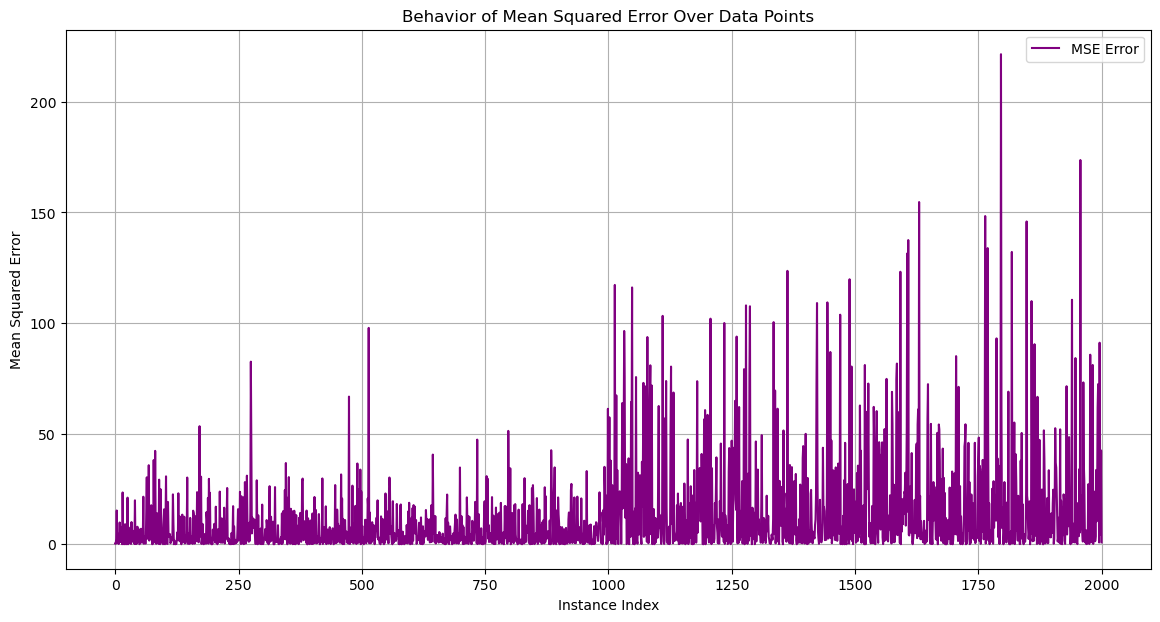

In [180]:
plot_errors(errors)

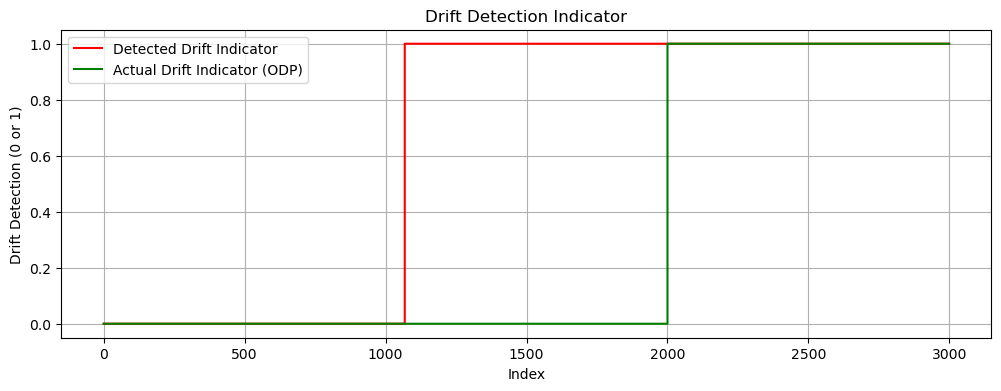

In [275]:
plot_drift_indicators(b, detected_drifts, odp)

## Best Parametrs

In [281]:
model=LinearRegression()

In [279]:
model=DecisionTreeRegressor()

In [ ]:
model=RandomForestRegressor()

In [ ]:
model=SVR()

In [283]:
pipeline=train_model(train,model)

In [285]:
quantile_threshold = 0.95 

In [287]:
detector=setup_ddm(warning_level=2.0, drift_level=3.0, min_num_instances=30)

In [228]:
detector=setup_eddm(alpha=0.95, beta=0.9, level=2.0, min_num_misclassified_instances=30)

### best threshold for default values and LR

In [333]:
start=0.1
end=0.95
step_size=0.05

In [335]:
best_quantile, best_false_alarm_rate, best_detection_delay, best_detected_drifts = optimize_quantile(train, val, stream,detector,pipeline,start,end,step_size)

Calculated threshold at 10.0% quantile: 0.06885876366817083
Quantile: 0.10
Threshold: 0.07
False Alarm Rate: 100.00%
Detection Delay: 0
Calculated threshold at 15.000000000000002% quantile: 0.19060103310832174
Quantile: 0.15
Threshold: 0.19
False Alarm Rate: 100.00%
Detection Delay: 0
Calculated threshold at 20.000000000000004% quantile: 0.28072772181182504
Quantile: 0.20
Threshold: 0.28
False Alarm Rate: 100.00%
Detection Delay: 0
Calculated threshold at 25.000000000000007% quantile: 0.5034519503153829
Quantile: 0.25
Threshold: 0.50
False Alarm Rate: 100.00%
Detection Delay: 0
Calculated threshold at 30.000000000000004% quantile: 0.6276598400327815
Quantile: 0.30
Threshold: 0.63
False Alarm Rate: 100.00%
Detection Delay: 0
Calculated threshold at 35.00000000000001% quantile: 0.9023048921195691
Quantile: 0.35
Threshold: 0.90
False Alarm Rate: 100.00%
Detection Delay: 0
Calculated threshold at 40.000000000000014% quantile: 1.27300152413272
Quantile: 0.40
Threshold: 1.27
False Alarm Rate

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq\\backend\\cython\\checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt: 


KeyboardInterrupt: 

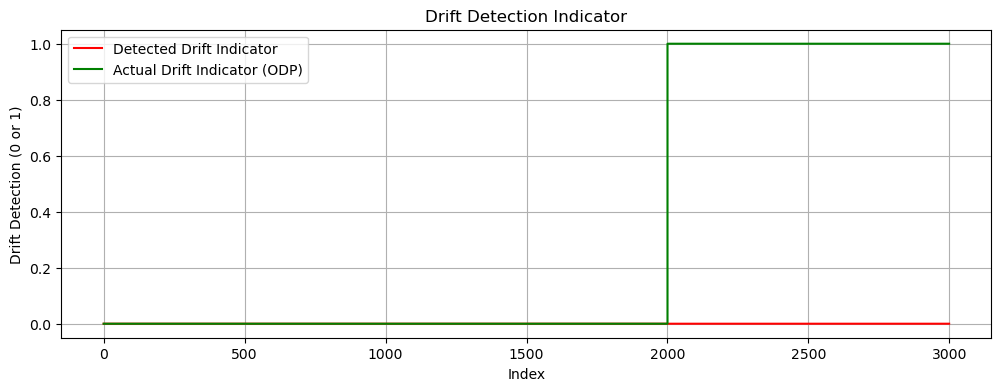

In [293]:
plot_drift_indicators(b, best_detected_drifts, odp)

### best drift level for default values and LR

In [230]:
start=0.05
end=0.5
step_size=0.05

In [236]:
best_drift_level, best_false_alarm_rate, best_detection_delay, best_detected_drifts=optimize_drift_level(train, val, stream, pipeline, best_quantile,start,end,step_size)

Calculated threshold at 50.0% quantile: 2.0317178910685834
Drift Level: 0.05
Threshold: 2.03
False Alarm Rate: 0.00%
Detection Delay: None
Drift Level: 0.10
Threshold: 2.03
False Alarm Rate: 0.00%
Detection Delay: None
Drift Level: 0.15
Threshold: 2.03
False Alarm Rate: 0.00%
Detection Delay: None
Drift Level: 0.20
Threshold: 2.03
False Alarm Rate: 0.00%
Detection Delay: None
Drift Level: 0.25
Threshold: 2.03
False Alarm Rate: 0.00%
Detection Delay: None
Drift Level: 0.30
Threshold: 2.03
False Alarm Rate: 0.00%
Detection Delay: None
Drift Level: 0.35
Threshold: 2.03
False Alarm Rate: 0.00%
Detection Delay: None
Drift Level: 0.40
Threshold: 2.03
False Alarm Rate: 0.00%
Detection Delay: None
Drift Level: 0.45
Threshold: 2.03
False Alarm Rate: 0.00%
Detection Delay: None
Best Drift Level: 0.45
Best False Alarm Rate: 0
Best Detection Delay: None
Best Detected Drifts: []


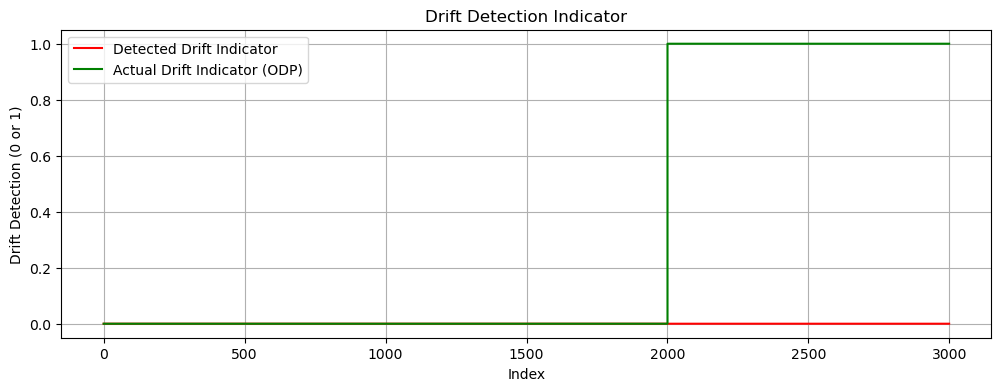

In [242]:
plot_drift_indicators(b, best_detected_drifts, odp)